In [16]:
# Load required packages
import torch
from torch import nn
from matplotlib import pyplot as plt
plt.rcParams['text.usetex'] = False
import numpy as np

# register acceleration devices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Load Benchmark Data

out = np.load('training-val-test-data.npz')
th_data = out['th'] #th[0],th[1],th[2],th[3],...
u_data = out['u'] #u[0],u[1],u[2],u[3],...

from sklearn import model_selection
u_train, u_val, y_train, y_val= model_selection.train_test_split(u_data, th_data, shuffle=False, test_size=0.3,random_state=42)
# Standardization
u_mean, u_std = np.mean(u_train),np.std(u_train)
y_mean, y_std = np.mean(y_train),np.std(y_train)


### Data to train and validate on ###:
u_train = (u_train-u_mean)/u_std #normalize
y_train = (y_train-y_mean)/y_std

u_val = (u_val-u_mean)/u_std
y_val = (y_val-y_mean)/y_std


def make_OE_data(udata, ydata, nf=100):
    U = []
    Y = []
    for k in range(nf,len(udata)+1):
        U.append(udata[k-nf:k]) #a)
        Y.append(ydata[k-nf:k]) #a)
    return np.array(U), np.array(Y)

nfuture = 30
convert = lambda x: [torch.tensor(xi,dtype=torch.float64,device=device) for xi in x]
Utrain, Ytrain = convert(make_OE_data(u_train, y_train, nf=nfuture))
Uval,   Yval   = convert(make_OE_data(u_val,   y_val,   nf=len(u_val))) #uses the whole data set for OE

cuda


In [23]:
# Code from EX3
class simple_RNN(nn.Module):
    def __init__(self, hidden_size):
        super(simple_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = 1
        self.output_size = 1
        net = lambda n_in,n_out: nn.Sequential(nn.Linear(n_in,40), \
                                               nn.Tanh(), \
                                               nn.Linear(40,n_out)).double() #new short hand
        self.h2h = net(self.input_size + hidden_size, self.hidden_size) #b=)
        self.h2o = net(self.input_size + hidden_size, self.output_size) #b=)
                                                                        #[:,0] should be called after use of h2o

    def forward(self, inputs):
        #input.shape == (N_batch, N_time)
        hidden = torch.zeros(inputs.shape[0], self.hidden_size, dtype=torch.float64, device=device) #c)
        outputs = [] #c)
        for i in range(inputs.shape[1]): #c)
            u = inputs[:,i] #shape = (N_batch,) #c)
            combined = torch.cat((hidden, u[:,None]), dim=1) #c) #shape = (N_batch,hidden_size+1)
            outputs.append(self.h2o(combined)[:,0]) #c)
            hidden = self.h2h(combined) #c)
        return torch.stack(outputs,dim=1) #c)

In [25]:

n_burn = 10
batch_size = 64

model = simple_RNN(hidden_size=15) #d=)
model = nn.DataParallel(model) # Wrap the model with DataParallel
model = model.to(device=device) # Move the model to the GPU
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) #d=)


ids = np.arange(len(Utrain),dtype=int)
for epoch in range(50):
    np.random.shuffle(ids) #inspace shuffle of the ids of the training set to select a random subset
    for i in range(0,len(Utrain),batch_size):
        ids_now = ids[i:i+batch_size] #the ids of the current batch
        Uin = Utrain[ids_now] #d)
        Y_real = Ytrain[ids_now] #d)
        model.train()
        Y_predict = model.forward(inputs=Uin) #d)
        residual = Y_real - Y_predict #d)
        Loss = torch.mean(residual[:,n_burn:]**2) #d)

        optimizer.zero_grad()  #d)
        Loss.backward()  #d)
        optimizer.step()  #d)

    with torch.no_grad(): #monitor
        model.eval()
        Loss_val = torch.mean((model(inputs=Uval)[:,n_burn:] - Yval[:,n_burn:])**2)**0.5
        Loss_train = torch.mean((model(inputs=Utrain)[:,n_burn:] - Ytrain[:,n_burn:])**2)**0.5
        print(f'epoch={epoch}, Validation NRMS={Loss_val.item():.2%}, Train NRMS={Loss_train.item():.2%}')

epoch=0, Validation NRMS=88.12%, Train NRMS=80.78%
epoch=1, Validation NRMS=64.67%, Train NRMS=67.96%
epoch=2, Validation NRMS=59.05%, Train NRMS=65.97%
epoch=3, Validation NRMS=60.86%, Train NRMS=64.78%
epoch=4, Validation NRMS=65.70%, Train NRMS=64.36%
epoch=5, Validation NRMS=66.56%, Train NRMS=63.93%
epoch=6, Validation NRMS=60.59%, Train NRMS=63.89%
epoch=7, Validation NRMS=68.28%, Train NRMS=63.64%
epoch=8, Validation NRMS=68.20%, Train NRMS=63.37%
epoch=9, Validation NRMS=65.83%, Train NRMS=63.20%
epoch=10, Validation NRMS=67.81%, Train NRMS=63.04%
epoch=11, Validation NRMS=63.77%, Train NRMS=63.03%
epoch=12, Validation NRMS=78.30%, Train NRMS=63.01%
epoch=13, Validation NRMS=72.02%, Train NRMS=62.83%
epoch=14, Validation NRMS=68.78%, Train NRMS=62.59%
epoch=15, Validation NRMS=67.33%, Train NRMS=62.88%
epoch=16, Validation NRMS=62.62%, Train NRMS=63.08%
epoch=17, Validation NRMS=67.93%, Train NRMS=62.93%
epoch=18, Validation NRMS=66.99%, Train NRMS=62.47%
epoch=19, Validation N

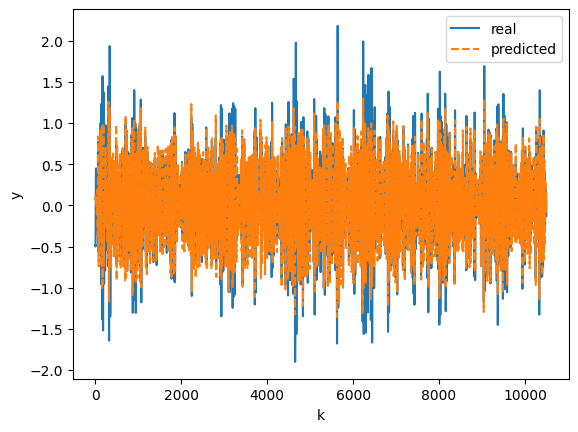

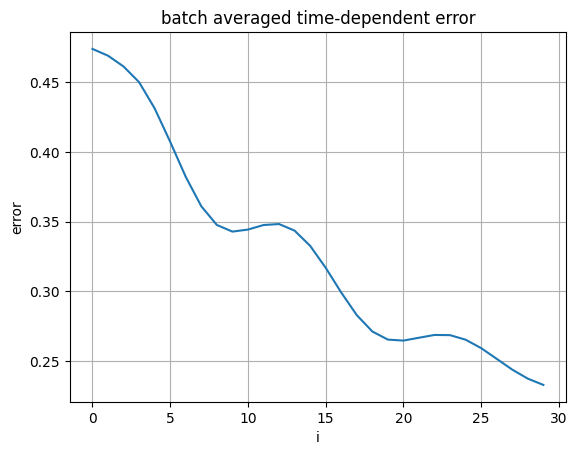

In [26]:
with torch.no_grad():
    plt.plot((Yval[0]*y_std + y_mean).cpu())
    model.eval()
    plt.plot((model(inputs=Uval)[0] * y_std + y_mean).cpu(),'--')
    plt.xlabel('k')
    plt.ylabel('y')
    #plt.xlim(0,250)
    plt.legend(['real','predicted'])
    plt.show()
    model.eval()
    plt.plot(np.mean(((Ytrain-model(inputs=Utrain))*y_std).cpu().numpy()**2,axis=0)**0.5) #average over the error in batch
    plt.title('batch averaged time-dependent error')
    plt.ylabel('error')
    plt.xlabel('i')
    plt.grid()
    plt.show()